In [3]:
import pandas as pd
import numpy as np
import os
import json
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats

file_name = "../raw_data/azurefunctions-dataset2019/invocations_per_function_md.anon.d"
train_file_names, test_file_names = [file_name+"%02d.csv" % (i) for i in range(1, 13)], [file_name+"13.csv", file_name+"14.csv"]

In [4]:
train_func_arrcount = {}
train_func_owner_app = {}
train_owner_func = defaultdict(set)
train_app_func = defaultdict(set)

func_trigger = defaultdict(set)

for i, file in enumerate(train_file_names):
    df = pd.read_csv(file)
    
    for _, row in df.iterrows():
        func = row["HashFunction"]
        train_func_owner_app[func] = row["HashOwner"]+'\t'+row["HashApp"]
        train_owner_func[row["HashOwner"]].add(func)
        train_app_func[row["HashApp"]].add(func)
        func_trigger[func].add(row["Trigger"])
        
        if func not in train_func_arrcount:
            train_func_arrcount[func] = [0]*12*1440
        train_func_arrcount[func][i*1440: (i+1)*1440] = list(row[4:].values)
    del df

test_func_arrcount = {}
test_func_owner_app = {}
test_owner_func = defaultdict(set)
test_app_func = defaultdict(set)

for i, file in enumerate(test_file_names):
    df = pd.read_csv(file)
    
    for _, row in df.iterrows():
        func = row["HashFunction"]
        test_func_owner_app[func] = row["HashOwner"]+'\t'+row["HashApp"]
        test_owner_func[row["HashOwner"]].add(func)
        test_app_func[row["HashApp"]].add(func)
        func_trigger[func].add(row["Trigger"])
        
        if func not in test_func_arrcount:
            test_func_arrcount[func] = [0]*2*1440    
        test_func_arrcount[func][i*1440: (i+1)*1440] = list(row[4:].values)
    del df
    
train_NUM, test_NUM = len(train_func_arrcount), len(test_func_arrcount)
train_NUM, test_NUM

(71616, 39388)

In [5]:
class func_state:
    def __init__(self, _type = 0, forget = 0):
        self.type = _type
        self.forget = forget
        
        self.state = False # loaded or not
        self.load_time = None 
        self.wait_time = None 
        self.last_call = None
        self.pre_call_start = None # start of the last calling series
        
        self.idle_info = {} 
        self.invok_info = {}
        
        self.pred_value = []
        self.next_invok_start = []
        
        self.adp_wait = []
    
    def load(self, load_time):
        self.state = True
        self.load_time = load_time
    
    def cal_lasting(self, cur_time):
        if not self.state:
            return 0
        return cur_time - load_time + 1
    
    def unload(self):
        self.state = False
        self.load_time = None
    
    def cal_wait(self):
        if self.wait_time is None:
            self.wait_time = 0
        self.wait_time += 1
    
    def reset(self, pred=False):
        self.unload()
        self.wait_time = None 
        self.last_call = None
        self.pre_call_start = None
        
        self.adp_wait = []
        
        if pred:
            self.next_invok_start = []

func_class = {}
for func in train_func_arrcount:
    func_class[func] = func_state()

In [6]:
FILL_ZERO_FLAG = True
shown_func_num = 1000
UNKNOWN, WARM, REGULAR, APPRO_REGULAR, DENSE, SUCCESSIVE, PLUSED, POSSIBLE, CORR, NEW_POSS = 0, 1, 2, 3, 4, 5, 6, 7, 8, 9 #Diviable? Active?
TYPE_NUM = 10

# Well-known Function Categorization

In [7]:
def conj_seq_lst(lst, count_invok=False, threshold=1):
    seq_lenth_lst = []
    pre_pos = -1
    for i, e in enumerate(lst):
        if not (bool(e) ^ count_invok):
            if pre_pos < 0:
                pre_pos = i
            if i == len(lst)-1 and i+1-pre_pos >= threshold:
                seq_lenth_lst.append(i+1-pre_pos)
        else:
            if pre_pos>=0 and i-pre_pos >= threshold:
                seq_lenth_lst.append(i-pre_pos)
            pre_pos = -1
    return seq_lenth_lst

In [8]:
def merge(lst):
    unique, counts = np.unique(lst, return_counts=True)
    mode = unique[np.argmax(counts)]
    if mode < 500: return lst
    if max(counts) < len(counts) / 2: return lst
    
    used = [False] * len(lst)
    new_lst = []

    for i in range(0, len(lst)):
        if lst[i] <= mode*0.25:
            continue
        else:
            cur = lst[i]
            for k in range(1, i+1):
                cur_idx = max(0, i-k)
                if lst[cur_idx] >= mode * 0.75: break
                if cur + lst[cur_idx] <= mode and lst[cur_idx] <= mode*0.25 and not used[cur_idx]:
                    used[cur_idx] = True
                    cur += lst[cur_idx]
            for k in range(1, len(lst)-i):
                cur_idx = min(len(lst)-1, i+k)
                if lst[cur_idx] >= mode * 0.75: break
                if cur + lst[cur_idx] <= mode and lst[cur_idx] <= mode*0.25 and not used[cur_idx]:
                    used[cur_idx] = True
                    cur += lst[cur_idx]
        new_lst.append(cur)
    
    if sum(used) / len(used) > 0.3:
        return lst
    
    return new_lst

### Always warm

In [9]:
always_num = 0
almost_num = 0

c = 0
with tqdm(total=train_NUM) as pbar:
    for func, arrcount in train_func_arrcount.items():
        c += 1
        if 0 not in arrcount:
            func_class[func].type = WARM
            always_num += 1
        
        elif np.count_nonzero(np.array(arrcount) == 0) < 0.001 * len(arrcount):
            func_class[func].type = WARM
            almost_num += 1
        
        if c % shown_func_num == 0:
            pbar.update(shown_func_num)

warm_num = almost_num + always_num
almost_num, always_num

 99%|███████████████████████████████████▋| 71000/71616 [01:27<00:00, 815.97it/s]


(1119, 720)

### Regular

In [10]:
SEQ_NUM_BOUND = 3 #Too infrequently invoked functions should not be categorized to this type.

regu1_num, regu2_num = 0, 0 
merge_num = 0

c = 0
with tqdm(total=train_NUM) as pbar:
    for func, arrcount in train_func_arrcount.items():
        c += 1
        if c % shown_func_num == 0:
            pbar.update(shown_func_num)
            
        if func_class[func].type >= REGULAR: 
            func_class[func].type = 0
        
        if func_class[func].type != 0: continue
            
        non_invok = conj_seq_lst(arrcount)
        invok = conj_seq_lst(arrcount, count_invok=True)
        
        if len(invok) >= SEQ_NUM_BOUND and len(non_invok) > 0:
            unique, counts = np.unique(non_invok, return_counts=True)
            mode = unique[np.argmax(counts)]
        
            if mode - non_invok[0] > 2:
                if arrcount[-1] > 0:
                    non_invok = non_invok[1:]
                else:
                    non_invok = non_invok[1:-1]
            
            if len(non_invok) > SEQ_NUM_BOUND:
                if np.percentile(non_invok, 95) - np.percentile(non_invok, 5) < 1:
                    func_class[func].type = REGULAR
                    regu1_num += 1
                elif np.std(non_invok) / np.mean(non_invok) <= 0.01:
                    func_class[func].type = REGULAR
                    regu2_num += 1
                
            ##slacking
            if FILL_ZERO_FLAG and func_class[func].type == 0:
                non_invok = merge(non_invok)
                
                if np.percentile(non_invok, 95) - np.percentile(non_invok, 5) < 1:
                    func_class[func].type = REGULAR
                    regu1_num += 1
                elif np.std(non_invok) / np.mean(non_invok) <= 0.01:
                    func_class[func].type = REGULAR
                    regu2_num += 1
                
                merge_num += (func_class[func].type == REGULAR)

        
regular_num = regu1_num + regu2_num
regular_num, regu1_num, regu2_num, merge_num

 99%|███████████████████████████████████▋| 71000/71616 [07:05<00:03, 167.03it/s]


(16193, 14809, 1384, 350)

### Appro Regular

In [11]:
IDLE_NUM_MAX = 3 #Consider the first n modes
IDLE_PERCEN = 0.9

appro_num = 0

c = 0
with tqdm(total=train_NUM) as pbar:
    for func, arrcount in train_func_arrcount.items():
        c += 1
        if c % shown_func_num == 0:
            pbar.update(shown_func_num)

        if func_class[func].type >= APPRO_REGULAR:
            func_class[func].type = 0
        
        if func_class[func].type == 0:
                
            non_invok = conj_seq_lst(arrcount)
            if len(non_invok) < SEQ_NUM_BOUND: continue
            
            non_invok_unique, non_invok_counts = np.unique(non_invok, return_counts=True)
            non_mode_max_index = np.argsort(-non_invok_counts)[:IDLE_NUM_MAX]
            
            if max(non_invok_counts) > 1:#If all WT values only appear once, it's meaningless.
                if sum(non_invok_counts[non_mode_max_index]) >= sum(non_invok_counts) * IDLE_PERCEN:
                    appro_num += 1
                    func_class[func].type = APPRO_REGULAR
                    
appro_num

 99%|███████████████████████████████████▋| 71000/71616 [02:54<00:01, 406.57it/s]


6242

### Dense

In [12]:
DENSE_UPPER_BOUND = 5 #the small constant
DENSE_PERCEN = 90

dense_num = 0

c = 0
with tqdm(total=train_NUM) as pbar:
    for func, arrcount in train_func_arrcount.items():
        c += 1
        if func_class[func].type >= DENSE:
            func_class[func].type = 0
        
        if func_class[func].type == 0:
            non_invok = conj_seq_lst(arrcount)
            if np.percentile(non_invok, DENSE_PERCEN) < DENSE_UPPER_BOUND:
                dense_num += 1
                func_class[func].type = DENSE
        
        if c % shown_func_num == 0:
            pbar.update(shown_func_num)

dense_num  

 99%|███████████████████████████████████▋| 71000/71616 [02:36<00:01, 452.51it/s]


405

### Successive

In [13]:
def cal_AN_seq(lst):
    seq_lenth_num = []
    pre_pos = -1
    for i, e in enumerate(lst):
        if bool(e):
            if pre_pos < 0:
                pre_pos = i
            if i == len(lst)-1 and i-pre_pos >= 0:
                seq_lenth_num.append(sum(lst[pre_pos:i+1]))
        else:
            if pre_pos >= 0 and i-pre_pos >= 1:
                seq_lenth_num.append(sum(lst[pre_pos:i]))
            pre_pos = -1
    return seq_lenth_num

In [14]:
gamma_1 = 10
gamma_2 = 11

successive_num = 0

c = 0
with tqdm(total=train_NUM) as pbar:
    for func, arrcount in train_func_arrcount.items():
        c += 1
        if func_class[func].type >= SUCCESSIVE:
            func_class[func].type = 0
            
        if func_class[func].type == 0:
            invok = conj_seq_lst(arrcount, count_invok=True)
            invok_seq_num = cal_AN_seq(arrcount)
            
            if min(invok) >= gamma_1 or min(invok_seq_num) >= gamma_2:
                successive_num += 1
                func_class[func].type = SUCCESSIVE
        
        if c % shown_func_num == 0:
            pbar.update(shown_func_num)

successive_num

 99%|███████████████████████████████████▋| 71000/71616 [03:11<00:01, 371.52it/s]


1683

## Forgetting

In [61]:
def re_categorzing(arrcount):
    #Always warm:
    if min(arrcount) > 0: 
        return WARM, 0
    if np.count_nonzero(np.array(arrcount) == 0) < 0.001 * len(arrcount):
        return WARM, 0
    
    invok = conj_seq_lst(arrcount, count_invok=True)
    non_invok = conj_seq_lst(arrcount)
    
    if len(invok) >= SEQ_NUM_BOUND:
        non_invok_reg = [i for i in non_invok]
        if arrcount[-1] == 0: #no so-called first WT
            non_invok_reg = non_invok_reg[:-1]
            
        if np.percentile(non_invok_reg, 95) - np.percentile(non_invok_reg, 5) < 1:
            return REGULAR, 1
        if np.std(non_invok_reg) / np.mean(non_invok_reg) <= 0.01:
            return REGULAR, 2
        
        if FILL_ZERO_FLAG:
            non_invok_reg = merge(non_invok_reg)
            if np.percentile(non_invok_reg, 95) - np.percentile(non_invok_reg, 5) < 1:
                return REGULAR, 1
            if np.std(non_invok_reg) / np.mean(non_invok_reg) <= 0.01:
                return REGULAR, 2
    
        non_invok_unique, non_invok_counts = np.unique(non_invok, return_counts=True)
        non_mode_max_index = np.argsort(-non_invok_counts)[:IDLE_NUM_MAX]

        #Appro Regular     
        if max(non_invok_counts) > 1 and \
            sum(non_invok_counts[non_mode_max_index]) >= sum(non_invok_counts) * IDLE_PERCEN:
            return APPRO_REGULAR, 0
    
    if np.percentile(non_invok, DENSE_PERCEN) < DENSE_UPPER_BOUND:
        return DENSE, 0
    
    if min(invok) >= gamma_1 or min(cal_AN_seq(arrcount)) > gamma_2:
        return SUCCESSIVE, 0
    
    return UNKNOWN, 0

In [62]:
DAY = 6
change_num_day = [0] * DAY
change_num = 0

regular_type_num = [0, 0, 0]
num_per_type = [0, warm_num, regular_num, appro_num, dense_num, successive_num, 0, 0, 0, 0]

for day in range(1, DAY + 1):
    print("^"*5, "Forgetting day", day, "^"*5)
    c = 0
    with tqdm(total=train_NUM) as pbar:
        for func in train_func_arrcount:
            c += 1
            if c % shown_func_num == 0:
                pbar.update(shown_func_num)
                
            if func_class[func].forget >= day:
                func_class[func].forget = 0
                func_class[func].type = 0
            
            if func_class[func].type == 0:
                arrcount = train_func_arrcount[func][1440*day: ]

                if sum(arrcount) > 0:
                    func_class[func].type, regular_type = re_categorzing(arrcount)
                    regular_type_num[regular_type] += 1

                    if func_class[func].type > 0:
                        change_num += 1
                        change_num_day[day - 1] += 1
                        func_class[func].forget = day
                        num_per_type[func_class[func].type] += 1
    
    print(change_num_day[day-1])

print("Regular num:", regular_type_num[1], regular_type_num[2])
num_per_type[0] = len(train_func_arrcount) - sum(num_per_type) #Unknown
change_num, "***", num_per_type[: SUCCESSIVE+1]

^^^^^ Forgetting day 1 ^^^^^


 99%|███████████████████████████████████▋| 71000/71616 [01:14<00:00, 953.15it/s]


169
^^^^^ Forgetting day 2 ^^^^^


 99%|██████████████████████████████████▋| 71000/71616 [00:58<00:00, 1206.83it/s]


171
^^^^^ Forgetting day 3 ^^^^^


 99%|██████████████████████████████████▋| 71000/71616 [00:45<00:00, 1559.76it/s]


218
^^^^^ Forgetting day 4 ^^^^^


 99%|██████████████████████████████████▋| 71000/71616 [00:32<00:00, 2204.50it/s]


230
^^^^^ Forgetting day 5 ^^^^^


 99%|██████████████████████████████████▋| 71000/71616 [00:21<00:00, 3276.35it/s]


269
^^^^^ Forgetting day 6 ^^^^^


 99%|██████████████████████████████████▋| 71000/71616 [00:15<00:00, 4438.81it/s]

3
Regular num: 92 80


(1060, '***', [44194, 1857, 16365, 6722, 459, 2019])

## Show & Save

In [66]:
pie_count = [0] * 6
before_forget_pie_count = [0] * 6

c = 0
with tqdm(total=train_NUM) as pbar:
    for func, arrcount in train_func_arrcount.items():
        c += 1
        if func_class[func].type >= PLUSED:
            func_class[func].type = 0
            
        pie_count[func_class[func].type] += 1
        
        if func_class[func].forget > 0:
            before_forget_pie_count[0] += 1
        else:
            before_forget_pie_count[func_class[func].type] += 1
        
        if c % shown_func_num == 0:
            pbar.update(shown_func_num)

pie_count[0]

 99%|████████████████████████████████▋| 71000/71616 [00:00<00:00, 824448.05it/s]


44194

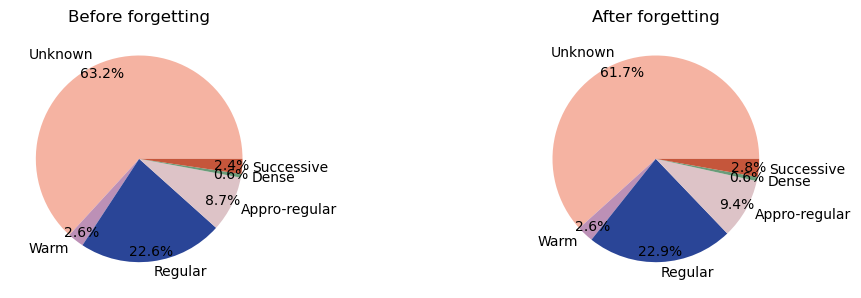

In [67]:
label_lst = ['Unknown','Warm', 'Regular', "Appro-regular", "Dense", "Successive"]
color_lst = ['#F5B3A2','#BC90B6','#2A4597','#DDC3C7', '#6A9C79', '#C5563B',"#F1AB3D", '#58A0A4','#E5F1E5',"#FBDEAF"]


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))
plt.subplots_adjust(wspace=1, hspace =0)

ax1.pie(np.array(before_forget_pie_count),
        labels = label_lst,
        colors = color_lst[:6],
        #explode = [0, 0.2, 0, 0, 0.7, 0, 0.1],
        autopct='%.1f%%',
        pctdistance=0.9,
       )
ax1.set_title('Before forgetting')

ax2.pie(np.array(pie_count),
        labels = label_lst,
        colors = color_lst[:6],
        #explode = [0, 0.2, 0, 0, 0.7, 0, 0.1],
        autopct='%.1f%%',
        pctdistance=0.9,
       )
ax2.set_title('After forgetting')

plt.show()

In [68]:
#Save categorization
import os
os.makedirs("mid-data", exist_ok=True)
with open("mid-data/train_info.txt", "w") as wf:
    for func, state in func_class.items():
        wf.write(func+'\t'+str(state.type)+'\t'+str(state.forget)+'\n')

In [69]:
#Save for calculating correlations

with open("mid-data/cal_corr/to_cal_corr.txt", "w") as wf:
    for func, arrcount in train_func_arrcount.items():
        wf.write(func+'\t'+str(func_class[func].forget)+'\t'+','.join(str(a) for a in arrcount)+'\n')

In [ ]:
to_cal_corr_num = 0
with open("mid-data/cal_corr/unknown_ownerapp_lst.txt", "w") as wf:
    for func, state in func_class.items():
        if state.type == 0:
            [owner, app] = train_func_owner_app[func].split('\t')
            ownerapp_lst = (train_owner_func[owner] | train_app_func[app])
            ownerapp_lst.remove(func)
            if len(ownerapp_lst) > 0:
                to_cal_corr_num += 1
                wf.write(func+'\t'+','.join(list(ownerapp_lst))+'\n')
to_cal_corr_num

## Indeterminte Function Assignment

In [72]:
valid_split_DAY = 9
func_valid_res = {func: {"cold": [20000]*3, "waste": [20000]*3} 
                  for func in train_func_arrcount 
                  if func_class[func].type >= PLUSED or func_class[func].type == 0
                 }

### Plused

In [73]:
PLUSED_GIVEUP = 3
useless_num = 0
takein_assign_num = 0

c = 0
with tqdm(total=train_NUM) as pbar:
    for func, arr in train_func_arrcount.items():
        c += 1
        if c % shown_func_num == 0:
            pbar.update(shown_func_num)
        
        if func_class[func].type >= PLUSED:
            func_class[func].type = 0
        if func_class[func].type != 0: continue
    
        valid_arr = arr[1440*valid_split_DAY: ]
        waste, used = 0, np.count_nonzero(valid_arr)
        cold_num, invok_num = 0, sum(valid_arr)
        
        if invok_num <= 0: 
            useless_num += 1
            continue
        
        takein_assign_num += 1
        
        state = False
        for i, cur_invok in enumerate(valid_arr):
            if cur_invok > 0:
                if not state:
                    state = True
                    cold_num += 1
            elif state:
                waste += 1
                if sum(valid_arr[max(0, i+1-PLUSED_GIVEUP): i]) == 0:
                    state = False
            
            func_valid_res[func]["cold"][0], func_valid_res[func]["waste"][0] = cold_num/invok_num, waste/used

useless_num, takein_assign_num  

 99%|██████████████████████████████████▋| 71000/71616 [00:52<00:00, 1362.74it/s]


(13277, 30917)

### Possible

In [74]:
PRE_WARM = 2
POSS_GIVEUP = 1
DISCRETE_TH = 10

takein_poss_num = 0
possible = set()

c = 0
with tqdm(total=train_NUM) as pbar:
    for func, arr in train_func_arrcount.items():
        c += 1
        if c % shown_func_num == 0:
            pbar.update(shown_func_num)
        
        if func_class[func].type >= POSSIBLE:
            func_class[func].type = 0
            
        if func_class[func].type != 0: continue
        train_arr, valid_arr = arr[:1440 * valid_split_DAY], arr[1440 * valid_split_DAY:]
        
        waste, used = 0, np.count_nonzero(valid_arr)
        cold_num, invok_num = 0, sum(valid_arr)
        
        non_invok = conj_seq_lst(arr)
        non_invok_unique, non_invok_counts = np.unique(non_invok, return_counts=True)
        
        if invok_num == 0: 
            if max(non_invok_counts) >= 2:
                possible.add(func)
            continue
        if max(non_invok_counts) < 2: continue
        
        takein_poss_num += 1
        state = False
        ############## Calculate ##############
        cut = min(5, sum(np.where(non_invok_counts > 1, 1, 0)))
        non_mode_max_index = np.argsort(-non_invok_counts)[:cut]
        modes = non_invok_unique[non_mode_max_index]
        
        if max(modes) - min(modes) <= DISCRETE_TH:
            pred_value = [min(modes), max(modes)]
            pred_value_discrete = False
        else:
            pred_value = sorted(list(modes))
            pred_value_discrete = True
        
        ############## Calculate ##############
        
        
        next_invok_start = []
        wait_time = 1440 * valid_split_DAY
        
        ############## Prewarming at time 0 ##############
        if np.count_nonzero(train_arr) > 0:
            last_call = np.where(np.array(train_arr) > 0)[0][-1] - len(train_arr)
            wait_time = non_invok[-1] if train_arr[-1] == 0 else 0
            if pred_value_discrete:
                next_invok_start = [(last_call + p + 1, last_call + p + 1) for p in pred_value]
            else:
                next_invok_start = [(last_call + pred_value[0] + 1, last_call + pred_value[1] + 1)]
        
            if train_arr[-1] > 0: state = True

        for (left, right) in next_invok_start:
            if left <= PRE_WARM and right >= -PRE_WARM:
                state = True
                break
        ############## Prewarming at time 0 ##############
        
        
        for i, cur_invok in enumerate(valid_arr):
            if cur_invok > 0:
                if not state:
                    state = True
                    cold_num += 1
                
                last_call = i
                wait_time = 0
                if pred_value_discrete:
                    next_invok_start = [(i + p + 1, i + p + 1) for p in pred_value]
                else:
                    next_invok_start = [(i + pred_value[0] + 1, i + pred_value[1] + 1)]
            else:
                wait_time += 1
                pre_warm_flag = False
                for (left, right) in next_invok_start:
                    if left <= i + PRE_WARM and right >= i - PRE_WARM:
                        pre_warm_flag = True
                        break      
                if state:
                    waste += 1
                    if (not pre_warm_flag) and wait_time >= POSS_GIVEUP:
                        state = False
                elif pre_warm_flag:
                    state = True
        
        func_valid_res[func]["cold"][1], func_valid_res[func]["waste"][1] = cold_num/invok_num, waste/used

takein_poss_num

 99%|███████████████████████████████████▋| 71000/71616 [03:53<00:02, 303.95it/s]


22148

### Correlated

#### Load Connections

In [123]:
import os 
import json
def read_json(filepath):
    if os.path.exists(filepath):
        assert filepath.endswith('.json')
        with open(filepath, 'r') as f:
            return json.loads(f.read())
    else: 
        print("File path "+filepath+" not exists!")
        return

train_candi = read_json("mid-data/func_candi.json")
    
len(train_candi)

27123

#### Calculate the predictive values of candidate functions

In [124]:
candi_pred_value = defaultdict(list)

c = 0
with tqdm(total=len(train_candi)) as pbar:
    for _, tri_tuple_lst in train_candi.items():
        c += 1
        if c % (shown_func_num) == 0:
            pbar.update(shown_func_num)
        
        for (candi_func, _, _) in tri_tuple_lst:
            if candi_func in candi_pred_value: continue
            
            arrcount = train_func_arrcount[candi_func][1440*func_class[candi_func].forget:]
            non_invok = conj_seq_lst(arrcount)

            if func_class[candi_func].type == REGULAR: 
                candi_pred_value[candi_func] = [np.median(non_invok)]

            elif func_class[candi_func].type in [APPRO_REGULAR, DENSE]:
                non_invok_unique, non_invok_counts = np.unique(non_invok, return_counts=True)
                non_mode_max_index = np.argsort(-non_invok_counts)[: min(5, sum(np.where(non_invok_counts > 1, 1, 0)))]
                
                if func_class[candi_func].type == APPRO_REGULAR:
                    candi_pred_value[candi_func] = non_invok_unique[non_mode_max_index[: min(len(non_mode_max_index), IDLE_NUM_MAX)]].tolist()

                elif func_class[candi_func].type == DENSE:
                    if len(non_mode_max_index) > 0:
                        candi_pred_value[candi_func] = [min(non_invok_unique[non_mode_max_index]), 
                                                        min(DENSE_UPPER_BOUND, max(non_invok_unique[non_mode_max_index]))]
                    else:
                        candi_pred_value[candi_func] = [min(non_invok_unique), min(DENSE_UPPER_BOUND, max(non_invok_unique))]       


100%|████████████████████████████████████▊| 27000/27123 [07:04<00:01, 63.64it/s]


#### Calculate the last call of candidate functions at each time i

In [125]:
candi_last_call_dict = {}

c = 0
with tqdm(total=len(train_candi)) as pbar:
    for _, tri_tuple_lst in train_candi.items():
        c += 1
        if c % (shown_func_num) == 0:
            pbar.update(shown_func_num)
        
        for (candi_func, _, _) in tri_tuple_lst:
            if candi_func in candi_last_call_dict: continue
            
            candi_func_arrcount = train_func_arrcount[candi_func][: 1440 * valid_split_DAY]
            if max(candi_func_arrcount) > 0:
                last_call = np.where(np.array(candi_func_arrcount) > 0)[0][-1] - len(candi_func_arrcount)
            else:
                last_call = None
            
            valid_arr = train_func_arrcount[candi_func][1440 * valid_split_DAY: ]
            candi_last_call_dict[candi_func] = [None] * len(valid_arr)
            
            for i, cur_invok in enumerate(valid_arr):
                if cur_invok > 0:
                    last_call = i
                    candi_last_call_dict[candi_func][i] = i
                else:
                    candi_last_call_dict[candi_func][i] = last_call

100%|███████████████████████████████████▊| 27000/27123 [00:46<00:00, 582.08it/s]


#### Run correlated validation

In [126]:
CORR_GIVEUP = 1

takein_corr_num = 0

c = 0
with tqdm(total=len(train_candi)) as pbar:
    for func, tri_tuple_lst in train_candi.items():
        c += 1
        if c % (shown_func_num/10) == 0:
            pbar.update(shown_func_num/10)
        
        if func_class[func].type >= CORR:
            func_class[func].type = 0
            
        if func_class[func].type != 0: continue
        
        train_arr, valid_arr = train_func_arrcount[func][:1440*valid_split_DAY], train_func_arrcount[func][1440*valid_split_DAY:]
        waste, used = 0, np.count_nonzero(valid_arr)
        cold_num, invok_num = 0, sum(valid_arr)
        if invok_num <= 0: continue
        
        takein_corr_num += 1
        
        next_invok_start = []
        ############## Calculate next_invok_start at time 0 ##############
        for (candi_func, lag, _) in tri_tuple_lst:
           
            candi_func_arrcount = train_func_arrcount[candi_func][: 1440 * valid_split_DAY]
            
            if np.count_nonzero(candi_func_arrcount) > 0:
                candi_last_call = np.where(np.array(candi_func_arrcount) > 0)[0][-1] - len(candi_func_arrcount)
                next_invok_start += [(candi_last_call, candi_last_call + lag)]

                if func_class[candi_func].type in [REGULAR, APPRO_REGULAR]:
                    next_invok_start += [(candi_last_call + 1 + p, candi_last_call + 1 + p + lag) 
                                           for p in candi_pred_value[candi_func]]
                elif func_class[candi_func].type == DENSE:
                    next_invok_start += [(candi_last_call + 1 + candi_pred_value[candi_func][0], 
                                            candi_last_call + 1 + candi_pred_value[candi_func][1] + lag)]
        
        ############## Calculate next_invok_start at time 0 ##############
        
        state = False
        wait_time = 1440 * valid_split_DAY
        
        ############## Prewarming at time 0 ##############
        if np.count_nonzero(train_arr) > 0:
            last_call = np.where(np.array(train_arr) > 0)[0][-1] - len(train_arr)
            wait_time = non_invok[-1] if train_arr[-1] == 0 else 0
            if train_arr[-1] > 0: state = True
        
        for (left, right) in next_invok_start:
            if left <= PRE_WARM and right >= -PRE_WARM:
                state = True
                break
        ############## Prewarming at time 0 ##############
        
        for i, cur_invok in enumerate(valid_arr):
            next_invok_start = []
            for (candi_func, lag, _) in tri_tuple_lst:
                if candi_last_call_dict[candi_func][i] is not None:
                    candi_last_call = candi_last_call_dict[candi_func][i]
                    next_invok_start += [(candi_last_call, candi_last_call + lag)]

                    if func_class[candi_func].type in [REGULAR, APPRO_REGULAR]:
                        next_invok_start += [(candi_last_call + 1 + p, candi_last_call + 1 + p + lag) 
                                               for p in candi_pred_value[candi_func]]

                    elif func_class[candi_func].type == DENSE:
                        next_invok_start += [(candi_last_call + 1 + candi_pred_value[candi_func][0], 
                                            candi_last_call + 1 + candi_pred_value[candi_func][1] + lag)]

            if cur_invok > 0:
                if not state:
                    state = True
                    cold_num += 1
                wait_time = 0
            
            else:
                wait_time += 1
                pre_warm_flag = False
                for (left, right) in next_invok_start:
                    if left <= i + PRE_WARM and right >= i - PRE_WARM:
                        pre_warm_flag = True
                        break

                if state:
                    waste += 1
                    if (not pre_warm_flag) and wait_time >= CORR_GIVEUP:
                        state = False
                elif pre_warm_flag:
                    state = True
                
        func_valid_res[func]["cold"][2], func_valid_res[func]["waste"][2] = cold_num/invok_num, waste/used

takein_corr_num

100%|█████████████████████████████████▉| 27100.0/27123 [04:10<00:00, 108.28it/s]


7077

### Assignment

In [127]:
alpha = 0.5

final_res = {}
good_assign_num, unknown_valid_num, bad_assign_num = 0, 0, 0
force_assign = [0] * 3


for func, res in func_valid_res.items():
    if min(res["cold"]) < 20000:
        
        cold_idx, waste_idx = np.argmin(res["cold"]), np.argmin(res["waste"])

        if cold_idx == waste_idx and res["cold"][cold_idx] < 1:
            final_res[func] = cold_idx
            good_assign_num += 1

        else:
            if cold_idx < waste_idx and res["cold"][cold_idx] == res["cold"][waste_idx]: #same cold, choose the smaller waste
                final_res[func] = waste_idx
                good_assign_num += 1
            elif waste_idx < cold_idx and res["waste"][cold_idx] == res["waste"][waste_idx]:
                final_res[func] = cold_idx
                good_assign_num += 1

            elif res["cold"][cold_idx] <= 0.1: #avoid zero division
                final_res[func] = cold_idx

            elif res["cold"][cold_idx] == 1:
                bad_assign_num += 1
                if func in possible:
                    final_res[func] = 1
                else:
                    final_res[func] = 0

            else:
                if func in possible:
                    final_res[func] = 1
                else:
                    delta_cold = alpha * (res["cold"][waste_idx] - res["cold"][cold_idx])/res["cold"][cold_idx]
                    delta_waste = (res["waste"][cold_idx] - res["waste"][waste_idx])/res["waste"][waste_idx]
                    if delta_cold <= delta_waste:
                        final_res[func] = cold_idx
                    else:
                        final_res[func] = waste_idx   

                force_assign[final_res[func]] += 1
    else:
        if func in possible:
            final_res[func] = 1
        else:
            unknown_valid_num += 1
        continue

for func, idx in final_res.items():
    func_class[func].type = PLUSED+idx

print(f"{len(final_res)} of the {pie_count[0]}, {len(func_valid_res)} unknown functions are assigned.") #len(final_res) + unknown_valid_num == pie_count[0]
print(f"{unknown_valid_num}/{useless_num} functions don't fit any of the three rules.")
print(takein_assign_num, takein_poss_num, takein_corr_num, "functions are tried to fit for the three rules.")
print(f"{good_assign_num} functions are assigned smoothly.")
print(f"{bad_assign_num} functions are assigned with a bad grace.")
print(f"{sum(force_assign)} functions are assigned forcibly: {force_assign[0]} are plused, {force_assign[1]} are possible, and {force_assign[2]} are CORR.")

33971 of the 10223, 44194 unknown functions are assigned.
10223/13277 functions don't fit any of the three rules.
30917 22148 7077 functions are tried to fit for the three rules.
5159 functions are assigned smoothly.
3862 functions are assigned with a bad grace.
10422 functions are assigned forcibly: 844 are plused, 7809 are possible, and 1769 are CORR.


In [128]:
cold_ratio = [func_valid_res[func]["cold"][idx] for func, idx in final_res.items()]
waste_ratio = [func_valid_res[func]["waste"][idx] for func, idx in final_res.items()]
np.percentile(cold_ratio, 75), np.median(waste_ratio), np.percentile(waste_ratio, 75)

(0.75, 4.334905660377358, 12.584119496855347)

### Record Corr candidate functions

In [129]:
candi_func_tuplelst = defaultdict(list)
all_corr_candi_num = 0

candi_dist = [0] * TYPE_NUM

for func, tri_tuple_lst in train_candi.items():
    if func_class[func].type == CORR:
        func_all_corr_candi = True
    
        for (candi, lag, _) in tri_tuple_lst:
            if candi not in candi_func_tuplelst:
                candi_dist[func_class[candi].type] += 1
                
            candi_func_tuplelst[candi].append((func, lag))
            if func_class[candi].type != CORR:
                func_all_corr_candi = False
    
        all_corr_candi_num += func_all_corr_candi

all_corr_candi_num

94

## Show & Save

In [131]:
pie_count = [0] * (TYPE_NUM - 1)
before_forget_pie_count = [0] * (TYPE_NUM - 1)

c = 0
with tqdm(total=train_NUM) as pbar:
    for func, arrcount in train_func_arrcount.items():
        c += 1
        if func_class[func].type > CORR:
            func_class[func].type = 0
            
        pie_count[func_class[func].type] += 1
        
        if func_class[func].forget > 0:
            before_forget_pie_count[0] += 1
        else:
            before_forget_pie_count[func_class[func].type] += 1
        
        if c % shown_func_num == 0:
            pbar.update(shown_func_num)

pie_count[0]

 99%|████████████████████████████████▋| 71000/71616 [00:00<00:00, 808012.92it/s]


10223

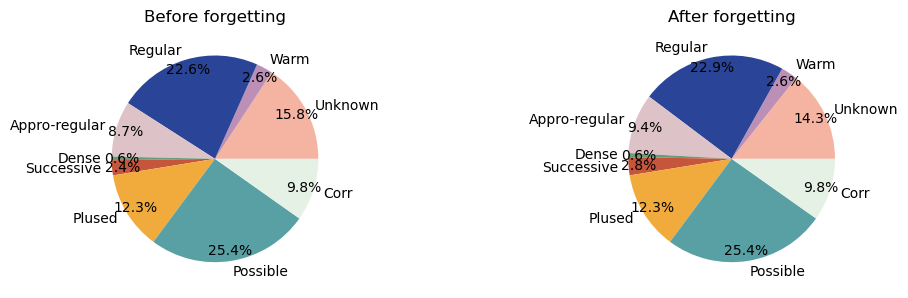

In [132]:
label_lst = ['Unknown','Warm', 'Regular', "Appro-regular", "Dense", "Successive", "Plused", "Possible", "Corr"]
color_lst = ['#F5B3A2','#BC90B6','#2A4597','#DDC3C7', '#6A9C79', '#C5563B',"#F1AB3D", '#58A0A4','#E5F1E5',"#FBDEAF"]


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))
plt.subplots_adjust(wspace=1, hspace =0)

ax1.pie(np.array(before_forget_pie_count),
        labels = label_lst,
        colors = color_lst[:TYPE_NUM-1],
        #explode = [0, 0.2, 0, 0, 0.7, 0, 0.1],
        autopct='%.1f%%',
        pctdistance=0.9,
       )
ax1.set_title('Before forgetting')

ax2.pie(np.array(pie_count),
        labels = label_lst,
        colors = color_lst[:TYPE_NUM-1],
        #explode = [0, 0.2, 0, 0, 0.7, 0, 0.1],
        autopct='%.1f%%',
        pctdistance=0.9,
       )
ax2.set_title('After forgetting')

plt.show()

#### Save categorization

In [133]:
os.makedirs("mid-data", exist_ok=True)
with open("mid-data/train_info_assigned.txt", "w") as wf:
    for func, state in func_class.items():
        wf.write(func+'\t'+str(state.type)+'\t'+str(state.forget)+'\n')

# Provision

### Calculate basic info

In [134]:
additional_poss_num = 0

c = 0
with tqdm(total=train_NUM) as pbar:
    for func in train_func_arrcount:
        func_class[func].reset(True)
        c += 1
        if c % shown_func_num == 0:
            pbar.update(shown_func_num)
            
        if func_class[func].type == WARM: continue
            
        func_class[func].pred_interval = [] #pred_value

        arrcount = train_func_arrcount[func][1440*func_class[func].forget:]
        func_class[func].last_call = np.where(np.array(arrcount)>0)[0][-1] - len(arrcount)
        #assert func_class[func].last_call < 0

        invok = conj_seq_lst(arrcount, count_invok=True)
        non_invok = conj_seq_lst(arrcount)

        func_class[func].wait_time = non_invok[-1] if arrcount[-1] == 0 else 0
        func_class[func].pre_call_start = func_class[func].last_call - invok[-1] + 1

        func_class[func].lasting_info = {"max": np.max(invok), "seq_num": len(invok)}
        func_class[func].idle_info = {"max": np.max(non_invok), "std": np.std(non_invok), "kind": len(set(non_invok))}
        
        if func_class[func].type == REGULAR:
            func_class[func].pred_interval = [np.median(non_invok)]
        
        else:
            non_invok_unique, non_invok_counts = np.unique(non_invok, return_counts=True)
            mode_cut = min(5, sum(np.where(non_invok_counts > 1, 1, 0)))
            ordered_index = np.argsort(-non_invok_counts)
            non_mode_max_index = ordered_index[: mode_cut]
            
            func_class[func].idle_info["mode"] = non_invok_unique[non_mode_max_index].tolist() #In the order of occuring count
            func_class[func].idle_info["mode_count"] = non_invok_counts[non_mode_max_index].tolist()

            if func_class[func].type == APPRO_REGULAR:
                #func_class[func].pred_interval = non_invok_unique[ordered_index[: min(len(ordered_index), IDLE_NUM_MAX)]].tolist()
                func_class[func].pred_interval = [non_invok_unique[idx] for idx in ordered_index[: min(len(ordered_index), IDLE_NUM_MAX)]
                                                                        if non_invok_counts[idx] > 0.1 * sum(non_invok_counts)]
                        
            elif func_class[func].type == DENSE:
                if len(non_mode_max_index) > 0:
                    func_class[func].pred_interval = [min(func_class[func].idle_info["mode"]),
                        min(10, max(func_class[func].idle_info["mode"]))]
                else:
                    func_class[func].pred_interval = [min(non_invok_unique), min(IDLE_NUM_MAX, max(non_invok_unique))]
            
            elif func_class[func].type == NEW_POSS:
                func_class[func].type = 0
            
            if func_class[func].type == POSSIBLE or (func_class[func].type == UNKNOWN and len(non_mode_max_index) > 0):
                additional_poss_num += (func_class[func].type == UNKNOWN)
                func_class[func].type = POSSIBLE
                if max(func_class[func].idle_info["mode"]) - min(func_class[func].idle_info["mode"]) <= DISCRETE_TH:
                    func_class[func].pred_interval = [min(func_class[func].idle_info["mode"]), 
                                                      max(func_class[func].idle_info["mode"])]
                    func_class[func].idle_info["pred_interval_discrete"] = False
                else: 
                    func_class[func].pred_interval = sorted(list(func_class[func].idle_info["mode"]))
                    func_class[func].idle_info["pred_interval_discrete"] = True


additional_poss_num

 99%|███████████████████████████████████▋| 71000/71616 [07:05<00:03, 166.96it/s]


0

### Rank func & Load simulating corr & Reset

#### Rank

In [135]:
func_lst, func_corr_lst = set(), set()

for func in func_class:
    if func_class[func].type == CORR:
        func_corr_lst.add(func)
    else:
        func_lst.add(func)

for func in test_func_arrcount:
    if func in func_class: continue
    func_lst.add(func)
    func_class[func] = func_state()

func_lst, func_corr_lst = list(func_lst), list(func_corr_lst)

len(func_class), len(func_lst)+len(func_corr_lst)

(72359, 72359)

#### Load simulating corrlations

In [136]:
test_func_corr = defaultdict(set)

for func, ownerapp in test_func_owner_app.items():
    if func not in train_func_arrcount:
        owner, app = ownerapp.split('\t')
        candi_func_set = (test_owner_func[owner] | test_app_func[app])
        if len(candi_func_set) == 1: continue
        
        candi_func_set.remove(func)
        for candi_func in candi_func_set:
            if len(func_trigger[func] & func_trigger[candi_func]) > 0:
                test_func_corr[func].add(candi_func)

test_func_corr_perform = {func: {candi_func: 0} for candi_func in test_func_corr[func]}

#### Reset

In [ ]:
for func in test_func_arrcount:
    if func in func_class and (func not in train_func_arrcount):
        del func_class[func]
    if func not in func_class:
        func_class[func] = func_state()

In [142]:
c = 0
with tqdm(total=train_NUM) as pbar:
    for func in train_func_arrcount:
        func_class[func].reset(True)
        c += 1
        if c % shown_func_num == 0:
            pbar.update(shown_func_num)
            
        if func_class[func].type == WARM: continue
        arrcount = train_func_arrcount[func][1440*func_class[func].forget:]
        func_class[func].last_call = np.where(np.array(arrcount)>0)[0][-1] - len(arrcount)
        invok = conj_seq_lst(arrcount, count_invok=True)
        non_invok = conj_seq_lst(arrcount)

        func_class[func].wait_time = non_invok[-1] if arrcount[-1] == 0 else 0
        func_class[func].pre_call_start = func_class[func].last_call - invok[-1] + 1

 99%|███████████████████████████████████▋| 71000/71616 [06:50<00:03, 173.12it/s]


## Calculate predictive values & predictions at time 0

In [143]:
PRE_WARM = 2
EN_STD = 2

GIVE_UP = {
    UNKNOWN: POSS_GIVEUP,
    WARM: 1440 * 14,
    REGULAR: 1,
    APPRO_REGULAR: 1,
    DENSE: DENSE_UPPER_BOUND,
    SUCCESSIVE: 1,
    PLUSED: PLUSED_GIVEUP,
    POSSIBLE: POSS_GIVEUP,
    CORR: CORR_GIVEUP,
    NEW_POSS: POSS_GIVEUP,
}

#### Predictive values

In [144]:
for func in train_func_arrcount: # calculate next invok start at time 0
    _type = func_class[func].type

    if _type == REGULAR: 
        p = func_class[func].last_call + 1
        if p < 0:
            p += (func_class[func].pred_interval[0] + 1)
        func_class[func].next_invok_start = [(p - min(func_class[func].idle_info["std"], EN_STD), 
                                              p + min(func_class[func].idle_info["std"], EN_STD))]

    elif _type == APPRO_REGULAR:
        func_class[func].next_invok_start = [(func_class[func].last_call + p + 1, func_class[func].last_call + p + 1) 
                                                 for p in func_class[func].pred_interval]
    elif _type == DENSE: 
        func_class[func].next_invok_start = [(func_class[func].last_call+func_class[func].pred_interval[0]+1,
                                             func_class[func].last_call+func_class[func].pred_interval[1]+1)]
    elif _type == CORR:
        func_class[func].next_invok_start = defaultdict(list)
        for (candi_func, lag, _ ) in train_candi[func]:
            func_class[func].next_invok_start[candi_func].append(
                (func_class[candi_func].last_call, func_class[candi_func].last_call + lag)
            )
            if func_class[candi_func].type != CORR: #otherwise, endless loop
                func_class[func].next_invok_start[candi_func] += [(nis[0], nis[1] + lag) for nis in func_class[candi_func].next_invok_start]

    elif _type in [POSSIBLE, NEW_POSS]:
        if func_class[func].idle_info["pred_interval_discrete"]:
            func_class[func].next_invok_start = [(func_class[func].last_call + p + 1, func_class[func].last_call + p + 1) 
                                                       for p in func_class[func].pred_interval]
        else:
            func_class[func].next_invok_start = [(func_class[func].last_call+func_class[func].pred_interval[0]+1,
                                            func_class[func].last_call+func_class[func].pred_interval[1]+1)]
    

#### Initialize memory

In [145]:
memory = set()

for func in train_func_arrcount: #Pre_warm for testing at time 0
    _type = func_class[func].type
    
    if _type == WARM:
        memory.add(func)
        func_class[func].load(0)

    elif _type in [SUCCESSIVE, CORR, POSSIBLE, NEW_POSS, UNKNOWN] and (func_class[func].last_call == -1):            
        memory.add(func)
        func_class[func].load(0)
    
    elif _type == PLUSED and (func_class[func].last_call + GIVE_UP[PLUSED] >= 0):
        memory.add(func)
        func_class[func].load(0)

    elif _type in [REGULAR, APPRO_REGULAR, DENSE] and func_class[func].last_call == -1 \
        and (func_class[func].lasting_info["max"] > 1 or func_class[func].lasting_info["seq_num"] == 1):
        memory.add(func)
        func_class[func].load(0)

    # Pre-warm funcs having next_invok_start
    if _type == CORR:
        flag = False
        for _, tuple_lst in func_class[func].next_invok_start.items():
            for (left, right) in tuple_lst:
                if left <= PRE_WARM and right >= -PRE_WARM:
                    memory.add(func)
                    func_class[func].load(0)
                    flag = True
                    break
            if flag: break
                
    elif _type in [REGULAR, APPRO_REGULAR, DENSE, POSSIBLE, NEW_POSS]:
        for (left, right) in func_class[func].next_invok_start:
            if left <= PRE_WARM and right >= -PRE_WARM:
                memory.add(func)
                func_class[func].load(0)
                break

# Simulating

In [146]:
CORR_REMOVAL_TH = 2

import bisect
import random

SHIFT = True #adaptive strategies
func_cold = {func: 0 for func in test_func_arrcount}
func_invok = {func: 0 for func in test_func_arrcount}

func_invok_bool = {func: 0 for func in test_func_arrcount}
func_waste = {func: 0 for func in test_func_arrcount}

waste_mem_time = 0

memory_size = []

In [147]:
with tqdm(total=1440 * 2) as pbar:
    for i in range(1440 * 2):
        if (i+1) % 40 == 0:  pbar.update(40)
        
        random.shuffle(func_corr_lst)
        for func in (func_lst + func_corr_lst): #In case of some functions staying in the memory forever
            _type = func_class[func].type
            
            if func in test_func_arrcount and test_func_arrcount[func][i] > 0: #invok
                func_invok[func] += test_func_arrcount[func][i]
                func_invok_bool[func] += 1
                
                if not func_class[func].state: #cold start
                    func_cold[func] += 1
                    func_class[func].load(i)
                    memory.add(func)
                
                if func_class[func].wait_time is None or func_class[func].wait_time > 0: #A new invocation seq begins currently
                    func_class[func].pre_call_start = i
                    func_class[func].adp_wait.append(func_class[func].wait_time)
                    
                    ## Shift: Update predictive values
                    if SHIFT and (_type in [REGULAR, DENSE, POSSIBLE, NEW_POSS, UNKNOWN]) and len(func_class[func].adp_wait) >= 5: # Adaptively Updating
                        if _type == REGULAR:
                            if abs(np.median(func_class[func].adp_wait) - func_class[func].pred_interval[0]) > max(1, func_class[func].idle_info["std"]):
                                func_class[func].pred_interval[0] = (func_class[func].pred_interval[0]+np.median(func_class[func].adp_wait))/2
                                
                        elif _type == DENSE:
                            if abs(min(func_class[func].adp_wait) - func_class[func].pred_interval[0]) > 1:
                                func_class[func].pred_interval[0] = min(func_class[func].adp_wait)
                            if (abs(max(func_class[func].adp_wait) - func_class[func].pred_interval[1]) > 1) \
                                and max(func_class[func].adp_wait) <= DENSE_UPPER_BOUND:
                                func_class[func].pred_interval[1] = max(func_class[func].adp_wait)
                        
                        elif _type in [POSSIBLE, NEW_POSS]:
                            idle_unique, idle_counts = np.unique(func_class[func].adp_wait, return_counts=True)
                            if max(idle_counts) >= max(2, func_class[func].idle_info["mode_count"][-1]):
                                idle_max_index = np.argsort(-idle_counts)
                                for idx in idle_max_index:
                                    if idle_unique[idx] in func_class[func].idle_info["mode"]: continue
                                    pos = len(func_class[func].idle_info["mode_count"]) - \
                                            bisect.bisect(func_class[func].idle_info["mode_count"][::-1], idle_counts[idx])
                                    if pos >= len(func_class[func].idle_info["mode_count"]): continue
                                        
                                    if idle_counts[idx] > func_class[func].idle_info["mode_count"][pos]:
                                        func_class[func].idle_info["mode_count"][pos] = idle_counts[idx]
                                        func_class[func].idle_info["mode"][pos] = idle_unique[idx]
                                    elif idle_counts[idx] == func_class[func].idle_info["mode_count"][pos]:
                                        func_class[func].idle_info["mode_count"].insert(pos, idle_counts[idx])
                                        func_class[func].idle_info["mode"].insert(pos, idle_unique[idx])

                                
                                if max(func_class[func].idle_info["mode"]) - min(func_class[func].idle_info["mode"]) <= DISCRETE_TH:
                                    func_class[func].pred_interval = [min(func_class[func].idle_info["mode"]), 
                                                      max(func_class[func].idle_info["mode"])]
                                    func_class[func].idle_info["pred_interval_discrete"] = False
                                else: 
                                    func_class[func].pred_interval = sorted(list(func_class[func].idle_info["mode"]))
                                    func_class[func].idle_info["pred_interval_discrete"] = True
                                
                        elif _type == UNKNOWN:
                            idle_unique, idle_counts = np.unique(func_class[func].adp_wait, return_counts=True)
                            idxs = np.argsort(-idle_counts)[: min(5, sum(np.where(idle_counts > 1, 1, 0)))]
                            mode_lst = idle_unique[idxs]
                            if len(mode_lst) > 0:
                                func_class[func].type = NEW_POSS
                                func_class[func].idle_info["mode"] = mode_lst.tolist()
                                func_class[func].idle_info["mode_count"] = idle_counts[idxs].tolist()
                                
                                if max(mode_lst) - min(mode_lst) <= DISCRETE_TH:
                                    func_class[func].idle_info["pred_interval_discrete"] = False
                                    func_class[func].pred_interval = [min(mode_lst), max(mode_lst)]
                                else:
                                    func_class[func].idle_info["pred_interval_discrete"] = True
                                    func_class[func].pred_interval = sorted(list(mode_lst))
                                
                func_class[func].wait_time = 0
                func_class[func].last_call = i
                
                #Update prediction for UNI, LIMITIDLE, DENSE, DIVI
                if _type == REGULAR:
                    func_class[func].next_invok_start = [(i + 1 + func_class[func].pred_interval[0] - min(func_class[func].idle_info["std"], EN_STD),
                                                          i + 1 + func_class[func].pred_interval[0] + min(func_class[func].idle_info["std"], EN_STD))]
                        
                elif _type == APPRO_REGULAR or (_type in [POSSIBLE, NEW_POSS] and func_class[func].idle_info["pred_interval_discrete"]):
                    func_class[func].next_invok_start = [(i + p + 1, i + p + 1) for p in func_class[func].pred_interval]
                
                elif _type == DENSE or (_type in [POSSIBLE, NEW_POSS] and (not func_class[func].idle_info["pred_interval_discrete"])):
                    func_class[func].next_invok_start = [(i + func_class[func].pred_interval[0] + 1, i + func_class[func].pred_interval[1] + 1)]
                
                #The occurrences of candidate functions can be predictive indicators.

                if func in candi_func_tuplelst: 
                    for (target_func, lag) in candi_func_tuplelst[func]: #func is candi, target is target
                        func_class[target_func].next_invok_start[func] = [(i, i + lag)]
                        if _type in [REGULAR, APPRO_REGULAR, DENSE, POSSIBLE, NEW_POSS]:
                            func_class[target_func].next_invok_start[func] += [(l, r + lag) 
                                                                             for (l, r) in func_class[func].next_invok_start]
                if func in test_func_corr:
                    for target_func in test_func_corr[func]:
                        if func_class[target_func].type == CORR:
                            func_class[target_func].next_invok_start[func] += [(i, i + 1)]
                            func_class[target_func].next_invok_start[func] = list(set(func_class[target_func].next_invok_start[func]))
                        else:
                            #assert not isinstance(func_class[post_func].next_invok_start, dict), post_func
                            func_class[target_func].next_invok_start += [(i, i + 1)]
                            func_class[target_func].next_invok_start = list(set(func_class[target_func].next_invok_start))
                        
            else: # not invok
                #func_class[func].cal_idle()
                if func_class[func].wait_time is None:
                    func_class[func].wait_time = 1
                else:
                    func_class[func].wait_time += 1
                    
                if func in memory:
                    waste_mem_time += 1
                    if func in func_waste:
                        func_waste[func] += 1
                
                # Prewarm according to different types
                pre_warm_flag = False
                
                if _type == REGULAR:
                    (p_small, p_large) = func_class[func].next_invok_start[0]
                    p_small += (func_class[func].pred_interval[0] + 1) * int(p_large <= i) #allow for one missing hit
                    func_class[func].next_invok_start[0] = (p_small, p_small + 2 * min(func_class[func].idle_info["std"], EN_STD))

                if _type in [REGULAR, APPRO_REGULAR, DENSE, POSSIBLE, NEW_POSS, UNKNOWN]:
                    for (left, right) in func_class[func].next_invok_start:
                        if left <= i + PRE_WARM and right >= i - PRE_WARM:
                            pre_warm_flag = True
                            break

                elif _type == CORR:
                    for tuple_lst in func_class[func].next_invok_start.values():
                        for (left, right) in tuple_lst:
                            if left <= i + PRE_WARM and right >= i - PRE_WARM:
                                pre_warm_flag = True
                                break
                        if pre_warm_flag: break
                
                if func_class[func].state and (not pre_warm_flag) and func_class[func].wait_time >= GIVE_UP[_type]: #Remove
                    memory.remove(func)
                    func_class[func].unload()
                
                elif pre_warm_flag:
                    memory.add(func)
                    func_class[func].load(i)

        memory_size.append(len(memory))
        
        ## Update test_corr
        for func, perform_dict in test_func_corr_perform:
            for candi in perform_dict:
                test_func_corr_perform[func][candi] += int(bool(test_func_arrcount[func][i]) & bool(test_func_arrcount[candi][i]))
        
        for func, perform_dict in test_func_corr_perform.items():
            best_perform = max(perform_dict.values())
            del_lst = []
            for candi, perform in perform_dict:
                if best_perform - perform >= CORR_REMOVAL_TH:
                    del_lst.append(candi)
            for candi in del_lst:
                del test_func_corr[func][candi]
                del test_func_corr_perform[func][candi]
        
cold_ratio = [cold/func_invok[func] for func, cold in func_cold.items()]
print("WMT:", waste_mem_time, waste_mem_time/2880)
print("Memory Usage", np.mean(memory_size), np.median(memory_size))
np.percentile(cold_ratio, 50), np.percentile(cold_ratio, 75), np.percentile(cold_ratio, 90)

100%|███████████████████████████████████████| 2880/2880 [15:37<00:00,  3.07it/s]

WMT: 21521200 7472.638888888889
Memory Usage 13982.138194444444 14167.5


(0.0, 0.10810810810810811, 0.6666666666666666)

# Result Save & Analysis

In [148]:
import json

def read_json(filepath):
    if os.path.exists(filepath):
        assert filepath.endswith('.json')
        with open(filepath, 'r') as f:
            return json.loads(f.read())
    else: 
        print("File path "+filepath+" not exists!")
        return
    
def json_pretty_dump(obj, filename):
    with open(filename, "w") as fw:
        json.dump(obj,fw, sort_keys=True, indent=4, separators=(",", ": "), ensure_ascii=False)

In [149]:
import time
os.makedirs("../result", exist_ok=True)

cur_time = time.strftime("%d-%H-%M", time.localtime())

json_pretty_dump(func_cold, f"../result/func_cold_{cur_time}.json")
json_pretty_dump(func_waste, f"../result/func_waste_{cur_time}.json")
json_pretty_dump(func_invok, f"../result/func_invok_{cur_time}.json")
json_pretty_dump(memory_size, f"../result/memory_size_{cur_time}.json")

## Anlysis

#### Cold start of each type

In [150]:
aim = np.percentile(cold_ratio, 75)
label_lst = ['Unknown','Warm', 'Regular', "Appro-regular", "Dense", "Successive", "Plused", "Possible", "Corr", "New_poss"]

cold_num_per_type = [0] * TYPE_NUM
invok_num_per_type = [0] * TYPE_NUM
cold_ratio_per_type_lst = [[] for _ in range(TYPE_NUM)]

for func, cold in func_cold.items():
    cold_num_per_type[func_class[func].type] += cold
    invok_num_per_type[func_class[func].type] += func_invok[func]
    cold_ratio_per_type_lst[func_class[func].type].append(cold / func_invok[func])

cold_ratio_exceed_num, cold_ratio_exceed_rate, cold_ratio75 =[0]*TYPE_NUM, [0]*TYPE_NUM, [0]*TYPE_NUM

for i, lst in enumerate(cold_ratio_per_type_lst):
    if len(lst) > 0:
        cold_ratio_exceed_num[i] = sum(np.where(np.array(lst)>=aim, 1, 0))
        cold_ratio_exceed_rate[i] = sum(np.where(np.array(lst)>=aim, 1, 0))/len(lst)
        cold_ratio75[i] = np.percentile(lst, 75)
    else:
        print(f"Empty Type {i}!")

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(10, 12))
plt.subplots_adjust(wspace=0, hspace=0.3)

ax1.bar(range(TYPE_NUM), 
        cold_num_per_type, 
        color=color_lst[:TYPE_NUM], 
        tick_label=label_lst
        )
ax1.set_title('Cold Start Num')

ax2.bar(range(TYPE_NUM), 
        invok_num_per_type, 
        color=color_lst[: TYPE_NUM], 
        tick_label=label_lst
        )
ax2.set_title('Invocation Num')

ax3.bar(range( TYPE_NUM), 
        cold_ratio_exceed_num, 
        color=color_lst[: TYPE_NUM],  
        tick_label=label_lst
        )
ax3.set_title('Cold Start Exceed Num')

ax4.bar(range( TYPE_NUM), 
        cold_ratio_exceed_rate, 
        color=color_lst[: TYPE_NUM],  
        tick_label=label_lst
        )
ax4.set_title('Cold Start Exceed Ratio')


plt.show()